<a href="https://colab.research.google.com/github/jakedorman64/internship/blob/main/Double_Pendulum_NeuralODE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [296]:
!pip install git+https://github.com/deepmind/dm-haiku
!pip install ipdb

  Cloning https://github.com/deepmind/dm-haiku to /tmp/pip-req-build-ot_pxq6g
  Running command git clone --filter=blob:none --quiet https://github.com/deepmind/dm-haiku /tmp/pip-req-build-ot_pxq6g
  Resolved https://github.com/deepmind/dm-haiku to commit 8000335cc6db7355343eb1e6110e4a1cdef75a12
  Preparing metadata (setup.py) ... done


In [322]:
from typing import Iterator, NamedTuple
import jax
import jax.numpy as jnp
from jax.numpy import pi, sin, cos
from jax import value_and_grad, jit
from jax import random
from jax.experimental.ode import odeint
from jax.config import config
import matplotlib.pyplot as plt
import imageio
import time
from tqdm.auto import trange
from matplotlib.patches import Circle
from functools import partial
from sklearn.model_selection import train_test_split
import haiku as hk
import optax
import ipdb

print(jax.lib.xla_bridge.get_backend().platform)

config.update("jax_disable_jit", False)
jax.config.update("jax_enable_x64", False)

# Define gravity
g = - 9.81
dt = 0.01
data_points = 2048
prediction_batch_size = 32
training_batch_size = 8
total_time = data_points * dt
gradient_updates = 20000

gpu


## Numerical Simulation to Generate Data

In [323]:
"""Define our differential equation"""

@jit
def dy_dt(y, t, g):
  # Create return array and unpack the values of y:

  theta_1 = y[0]
  theta_2 = y[1]
  omega_1 = y[2]
  omega_2 = y[3]

  # Make the equations nicer by setting these:
  s = sin(theta_1 - theta_2)
  c = cos(theta_1 - theta_2)

  # Derivative of the thetas are just the omegas:
  dtheta1_dt = omega_1
  dtheta2_dt = omega_2

  # Derivative of the omegas:
  domega1_dt = ( g * sin(theta_2) * c - s * ((omega_1 ** 2) * c + (omega_2 ** 2)) - 2 * g * sin(theta_1) ) / (1 + s ** 2)

  domega2_dt = ( 2 * ( (omega_1 ** 2) * s - g * sin(theta_2) + g * sin(theta_1) * c ) + (omega_2 ** 2) * s * c ) / (1 + s ** 2)

  dy_dt = jnp.array([dtheta1_dt, dtheta2_dt, domega1_dt, domega2_dt])
  return dy_dt

In [324]:
"""Generate our initial data point and the time array"""


# key, subkey = random.split(random.PRNGKey(int(time.time())))
# theta_1_init = random.uniform(key, minval = 0, maxval = 2 * pi)
# theta_2_init = random.uniform(subkey, minval = 0, maxval = 2 * pi)

# key, subkey = random.split(key)
# omega_1_init = random.uniform(key, minval = -5, maxval = 5)
# omega_2_init = random.uniform(key, minval = -5, maxval = 5)

theta_1_init = pi + 1
theta_2_init = pi + 1
omega_1_init = 0
omega_2_init = 0

init = jnp.array([theta_1_init, theta_2_init, omega_1_init, omega_2_init])

# And generate our time array:
tsteps = jnp.linspace(0, total_time, data_points)

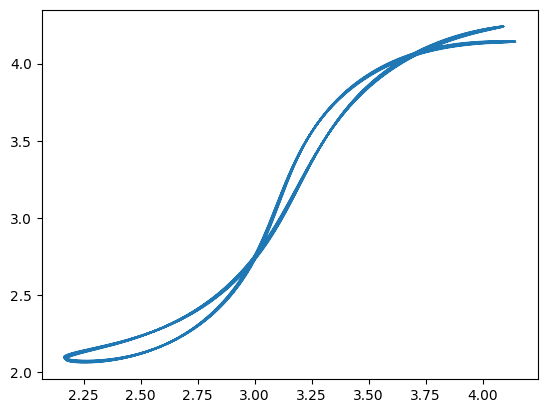

In [325]:
"""Generate our data and display it"""

generated_data = odeint(dy_dt, init, tsteps, g)
plt.plot(generated_data[:, 0], generated_data[:, 1])

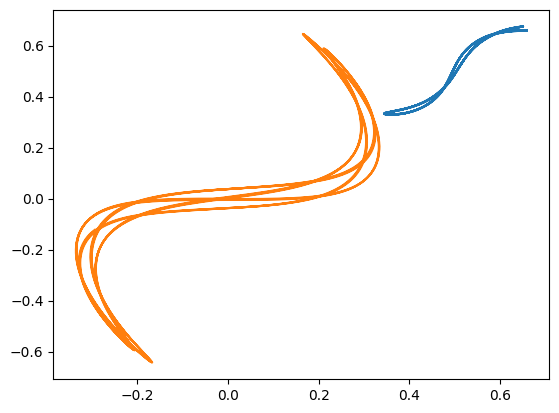

In [326]:
""" Normalise our generated data and display it.

    To normalise our angles, we can modulo by 2 * pi and then divide by 2 * pi, to get between 0 and 1.
    For the angular velocities, we can add 100 and then divide by 200.

    CURRENT THEORY AS TO WHY IT ISN'T WORKING:
    Normalising the data means ruining the scale that comes from position, velocity and acceleration being in the same units.
    odeint probably can't handle things being in different scales perhaps?
"""

def modulo_two_pi(x):
  return x % (2 * pi)

normalised_data = generated_data
normalised_data = normalised_data.at[:,:2].apply(modulo_two_pi)
normalised_data = normalised_data.at[:,:2].divide(2 * pi)

normalised_data = normalised_data.at[:,2:].divide(2 * pi)

plt.plot(normalised_data[:, 0], normalised_data[:, 1])
plt.plot(normalised_data[:, 2], normalised_data[:, 3])

## Create the network.

In [327]:
""" Split our data into training and test data.

      The x data will be the vector of the initial point:

              x_0 = ( theta_1,0 theta_2,0 omega_1,0 omega_2,0 ).

      The y data will be an array containing just the angle vectors of the consecutive points in the generated data:

              y_0 = ((theta_1,1 theta_2,1), (theta_1,2 theta_2,2), ... , (theta_1,n theta_2,n)).

"""

x_data = []
y_data = []

for i in range(data_points - prediction_batch_size - 1):
  x_data.append(normalised_data[i])
  y_data.append(normalised_data[i+1 : i + prediction_batch_size + 1, :2])

x_data = jnp.array(x_data)
y_data = jnp.array(y_data)

# Split the data. We need shuffle to be 0 to preserve the time series.
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, random_state=42)

In [328]:
"""Define our dataset, batch and training state classes."""

class Dataset:
  """An iterator over a numpy array, revealing batch_size elements at a time."""
  # Initialise our dataset class. It needs the full x and y values and a batch size to be initialised.
  def __init__(self, x: jnp.array, y: jnp.array, batch_size: int):
    self._x = x
    self._y = y
    self._batch_size = batch_size
    self._length = self._x.shape[0]
    # The id stores where the next datapoint should be taken from, so when initialised it should be 0.
    self._idx = 0

  # This is the function that gives us our next batch of data.
  def __next__(self):
    # Select the first and last datapoints in the batch. First will be the current value of the ID
    start = self._idx
    end = start + self._batch_size
    # Select our data.
    if end > self._length:
      x, y = jnp.concatenate((self._x[start:self._length], self._x[0:end - self._length]), axis=0), jnp.concatenate((self._y[start:self._length], self._y[0:end - self._length]), axis=0)
    else:
      x, y = self._x[start:end], self._y[start:end]
    # This resets us back to 0 once we reach the end of our data.
    if end >= self._length:
      end = end % self._length
      # assert end == 0  # Guaranteed by ctor assertion.
    self._idx = end
    return x, y

class Batch(NamedTuple):
  input: jnp.ndarray
  output: jnp.ndarray

class TrainingState(NamedTuple):
  params: hk.Params
  opt_state: optax.OptState

In [329]:
"""Define our datasets"""

train_dataset = Dataset(x_train, y_train, training_batch_size)
eval_dataset = Dataset(x_test, y_test, training_batch_size)

In [339]:
"""Define the neural network, and initiate it and the optimizer."""

def FeedForward(x):
  mlp = hk.Sequential([
      hk.Linear(16), jax.nn.relu,
      hk.Linear(16), jnp.tanh,
      hk.Linear(2),
  ])
  return mlp(x)

# Define our network and optimiser.
network = hk.without_apply_rng(hk.transform(FeedForward))
optimiser = optax.adam(1e-3)

# This is a time array of the consecutive points after our input in the training data.
training_steps = jnp.array([i*dt for i in range(prediction_batch_size + 1)])

In [340]:
"""Define our mean squared error loss."""

@jit
def nn_predict(x, t, weights):
  # Our network only predicts the acceleration. Since we are using odeint on it, we need input and output to be the same shape, so we can attach the velocities directly
  # onto it too.
  accel = network.apply(weights, x)
  veloc = x[2:]
  y = jnp.hstack((veloc, accel))
  return y

@jit
def modulo_one(x):
  return x % 1

@jit
def normalise_predictions(preds):
  preds = preds.at[:,:2].apply(modulo_one)
  return preds

@jit
def MeanSquaredErrorLoss(weights, batch):
  # WLOG, we can set each time series as starting from 0.
  # This array will hold our predictions for each prediction batch.
  x = batch[0]
  y = batch[1]
  preds = jnp.empty_like(y)
  # Make our predictions. Our output data is periodic between (-1, 1), but odeint doesn't know that it has to stay within these bounds. Thus,
  # we will have to manually normalise it. To do this, we can add 1 so it is periodic between (0, 2), module by 2, and then subtract 1 again.
  for i in range(training_batch_size):
    prediction = odeint(nn_predict, x[i], training_steps, weights)
    # odeint will include the initial value, so we can remove this, and we can also remove the angular velocities as these should not count towards the loss.
    prediction = prediction[1:, :2]
    # We need to normalise the prediction as it may not stay in the bounds of (-1, 1).
    prediction = normalise_predictions(prediction)
    # This adds the prediction for batch i to the preds tuple.
    preds = preds.at[i].set(prediction)

  return jnp.power(y - preds, 2).mean()

In [341]:
"""Define what happens on each gradient update"""

@jit
def update(state: TrainingState, batch: Batch) -> TrainingState:
  # This is how we define our stochastic gradient descent.
  # Find grads of loss w.r.t parameters, on this batch of the data
  grads = jax.grad(MeanSquaredErrorLoss)(state.params, batch)
  # Get the updates and the new optimser state from this.
  updates, opt_state = optimiser.update(grads, state.opt_state)
  # Apply the updates to the parameters.
  params = optax.apply_updates(state.params, updates)

  #return the training state with the new parameters and the optimiser.
  return TrainingState(params, opt_state)

In [342]:
"""Initialise our parameters and state the shape of our network to check all is okay."""

#Initialising the parameters randomly.
rng = jax.random.PRNGKey(200)
initial_params = network.init(rng, x_train[1])

# Initialise the optimiser and the define the state.
initial_opt_state = optimiser.init(initial_params)
state = TrainingState(initial_params, initial_opt_state)

# Print the structure of the network.
print("Weights Type : {}\n".format(type(initial_params)))

for layer_name, weights in initial_params.items():
    print(layer_name)
    print("Weights : {}, Biases : {}\n".format(initial_params[layer_name]["w"].shape,initial_params[layer_name]["b"].shape))

Weights Type : <class 'dict'>

linear
Weights : (4, 16), Biases : (16,)

linear_1
Weights : (16, 16), Biases : (16,)

linear_2
Weights : (16, 2), Biases : (2,)



In [343]:
"""Training & evaluation loop."""

train_loss_list = []
val_loss_list = []
for step in range(gradient_updates):
  # Do stochastic gradient descent on a batch of training examples.
  state = update(state, next(train_dataset))

  # Print the training and evaluation loss every 1000 time steps. We normalise the loss so that if we change batch size, the loss stays at the same scale.

  if step % 100 == 0:
    train_loss_list.append(MeanSquaredErrorLoss(state.params, next(train_dataset)))
    val_loss_list.append(MeanSquaredErrorLoss(state.params, next(eval_dataset)))
    print("Step {}: train loss {}, eval loss {}".format(step, train_loss_list[-1], val_loss_list[-1]))

Step 0: train loss 0.0003906381316483021, eval loss 0.00034814304672181606
Step 100: train loss 0.00041280518053099513, eval loss 0.0004720315628219396
Step 200: train loss 0.00047643244033679366, eval loss 0.00048421931569464505
Step 300: train loss 0.00035173213109374046, eval loss 0.0004532730090431869
Step 400: train loss 0.0005041381227783859, eval loss 0.00044467445695772767
Step 500: train loss 0.00040278222877532244, eval loss 0.00042215033317916095
Step 600: train loss 0.00039007136365398765, eval loss 0.00037158571649342775


KeyboardInterrupt: ignored

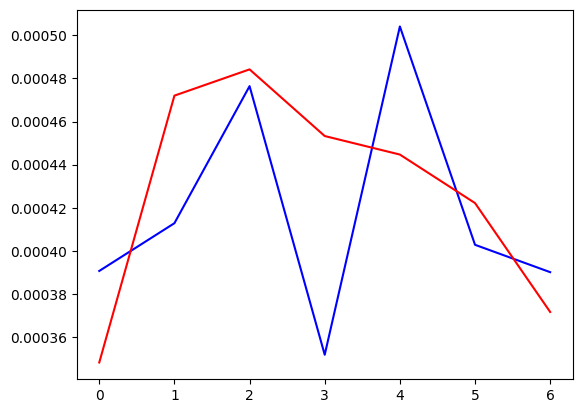

In [344]:
"""Plot the loss."""

plt.plot(train_loss_list, color="b")
plt.plot(val_loss_list, color="red")

[[ 6.5915489e-01  6.5915489e-01  0.0000000e+00  0.0000000e+00]
 [ 6.5908915e-01  6.5915489e-01 -1.3142061e-02 -2.3257501e-06]
 [ 6.5889293e-01  6.5915489e-01 -2.6270149e-02 -1.8680259e-05]
 ...
 [ 3.9588249e-01  3.5501021e-01 -3.0506977e-01 -1.3938314e-01]
 [ 3.9285660e-01  3.5365981e-01 -2.9981509e-01 -1.3065901e-01]
 [ 3.8988557e-01  3.5239348e-01 -2.9406181e-01 -1.2246102e-01]]
[[ 6.5915489e-01  6.5915489e-01  0.0000000e+00  0.0000000e+00]
 [ 6.5915191e-01  6.5915728e-01 -5.6303135e-04  5.1336380e-04]
 [ 6.5914363e-01  6.5916514e-01 -1.1233229e-03  1.0255612e-03]
 ...
 [ 6.6853333e-01  3.3783722e-01 -1.7434729e+01  5.1468358e+00]
 [ 4.9414825e-01  3.8930893e-01 -1.7448648e+01  5.1491814e+00]
 [ 3.1958008e-01  4.4081497e-01 -1.7462574e+01  5.1515269e+00]]


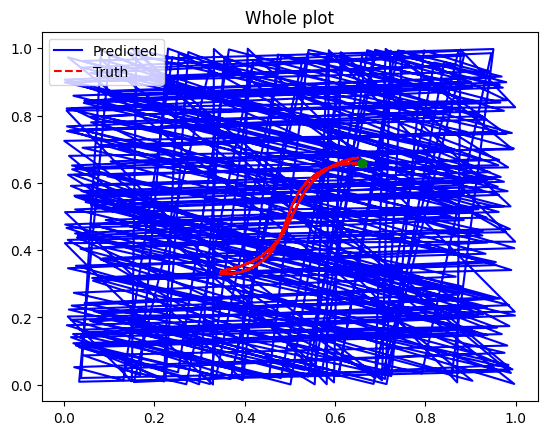

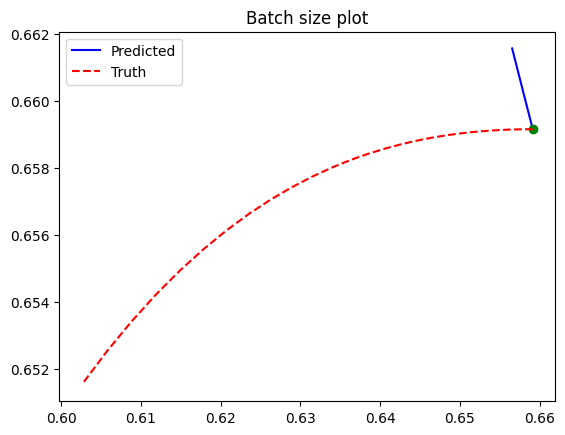

In [345]:
"""Generate and plot the angles."""

# Generate data from our neural network. odeint doesn't know to normalise it, so we will normalise it in the same way as before.
# Our initial value will be the first point in our normalised data array.
full_steps = jnp.array([dt*i for i in range(data_points)])

print(normalised_data)

#predicted_data = jnp.array(euler_integrator(normalised_data[0], state.params, data_points))
predicted_data = odeint(nn_predict, normalised_data[0], full_steps, state.params)
predicted_data = normalise_predictions(predicted_data)

print(predicted_data)

plt.plot(predicted_data[:, 0], predicted_data[:, 1], color="blue", label="Predicted")
plt.plot(normalised_data[:, 0], normalised_data[:, 1], color="red", label="Truth", linestyle="dashed")
plt.plot(normalised_data[0,0], normalised_data[0,1], "o", color="green")
plt.legend()
plt.title("Whole plot")
plt.show()
plt.close()

plt.plot(predicted_data[:prediction_batch_size, 0], predicted_data[:prediction_batch_size, 1], color="blue", label="Predicted")
plt.plot(normalised_data[0,0], normalised_data[0,1], "o", color="green")
plt.plot(normalised_data[:prediction_batch_size, 0], normalised_data[:prediction_batch_size, 1], color="red", label="Truth", linestyle="dashed")
plt.legend()
plt.title("Batch size plot")
plt.show()
plt.close()